In [8]:
import pandas as pd
import numpy as np
from datetime import datetime
import re
import pytz
from IPython.display import display
import matplotlib.pyplot as plt
import sys
import os
import seaborn as sns

=== News Dataset Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 5 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   headline   1048575 non-null  object
 1   url        1048575 non-null  object
 2   publisher  1048575 non-null  object
 3   date       1048575 non-null  object
 4   stock      1048575 non-null  object
dtypes: object(5)
memory usage: 40.0+ MB

=== Stock Dataset Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10998 entries, 0 to 10997
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          10998 non-null  object 
 1   Open          10998 non-null  float64
 2   High          10998 non-null  float64
 3   Low           10998 non-null  float64
 4   Close         10998 non-null  float64
 5   Adj Close     10998 non-null  float64
 6   Volume        10998 non-null  int64  
 7   Divide

,headline,url,publisher,date,stock
0,Stocks That Hit 52-Week Highs On Friday,https://www.benzinga.com/news/20/06/16190091/s...,Benzinga Insights,2020-06-05 10:30:54-04:00,A
1,Stocks That Hit 52-Week Highs On Wednesday,https://www.benzinga.com/news/20/06/16170189/s...,Benzinga Insights,2020-06-03 10:45:20-04:00,A
2,71 Biggest Movers From Friday,https://www.benzinga.com/news/20/05/16103463/7...,Lisa Levin,2020-05-26 04:30:07-04:00,A
3,46 Stocks Moving In Friday's Mid-Day Session,https://www.benzinga.com/news/20/05/16095921/4...,Lisa Levin,2020-05-22 12:45:06-04:00,A
4,B of A Securities Maintains Neutral on Agilent...,https://www.benzinga.com/news/20/05/16095304/b...,Vick Meyer,2020-05-22 11:38:59-04:00,A



=== Stock Dataset Sample ===


,Date,Open,High,Low,Close,Adj Close,Volume,Dividends,Stock Splits
0,1980-12-12,0.128348,0.128906,0.128348,0.128348,0.098943,469033600,0.0,0.0
1,1980-12-15,0.122210,0.122210,0.121652,0.121652,0.093781,175884800,0.0,0.0
2,1980-12-16,0.113281,0.113281,0.112723,0.112723,0.086898,105728000,0.0,0.0
3,1980-12-17,0.115513,0.116071,0.115513,0.115513,0.089049,86441600,0.0,0.0
4,1980-12-18,0.118862,0.119420,0.118862,0.118862,0.091630,73449600,0.0,0.0


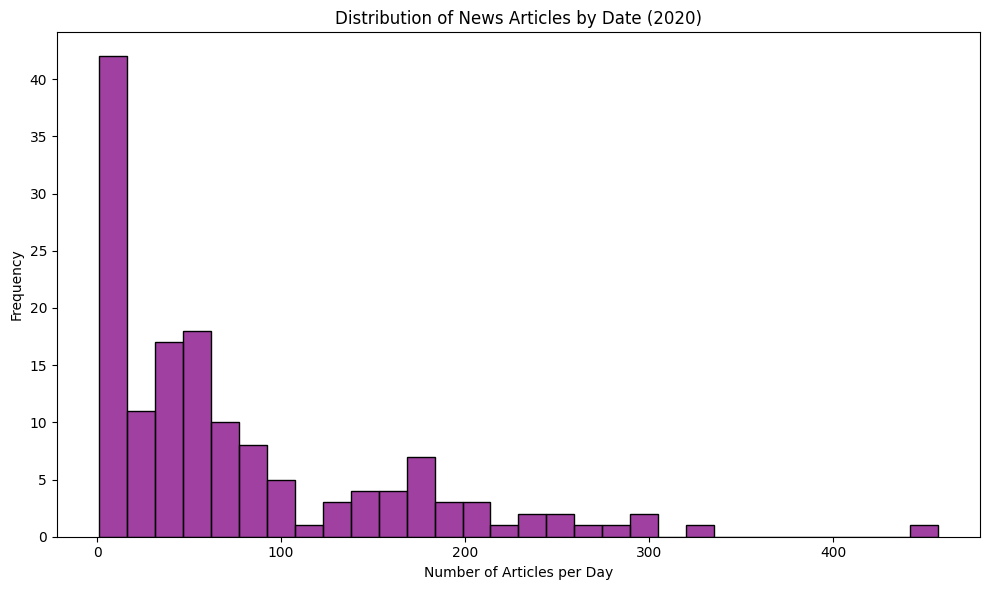

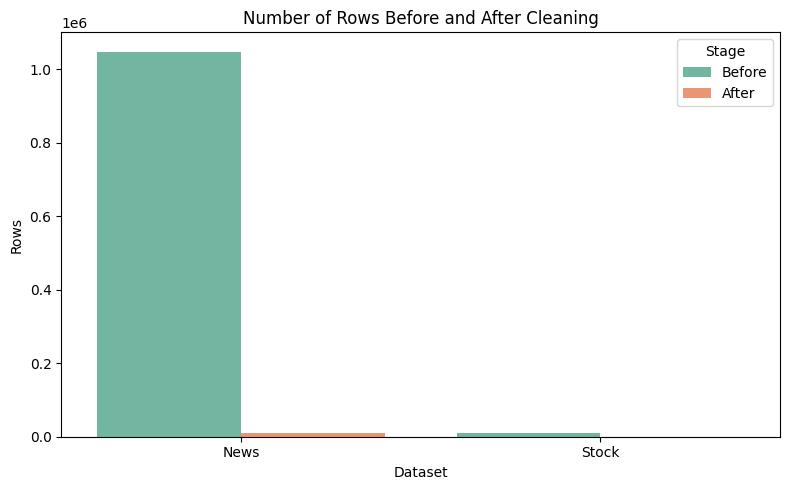


=== Cleaning Summary ===
News Dataset Columns: ['headline', 'url', 'publisher', 'date', 'stock', 'date_only']
Stock Dataset Columns: ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'stock']
News Dataset (2020): 11249 rows after cleaning
Stock Dataset (2020): 253 rows after cleaning


In [9]:

# ---
# title: Data Cleaning and Visualization for Financial News and Stock Price Datasets (2020)
# description: Notebook to clean and visualize 2020 data from raw news and AAPL stock price datasets
# ---

# ### 1. Import Libraries and Adjust Python Path
# Add project root to Python path
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

from src.data_utils import (
    load_and_validate_dataset,
    clean_and_prepare_news_data,
    clean_and_prepare_stock_data
)

# ### 2. Load Datasets Using Functions
news_columns = ['headline', 'url', 'publisher', 'date', 'stock']
stock_columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']
YEAR = 2020  # Selected year for processing

# Load datasets and store original row counts
news_df = load_and_validate_dataset('../data/raw_news_analysize/raw_news.csv', expected_columns=news_columns)
stock_df = load_and_validate_dataset('../data/yfinance_data/AAPL_historical_data.csv', expected_columns=stock_columns)

# Check if datasets loaded successfully
if news_df is None or stock_df is None:
    raise SystemExit("Failed to load datasets. Check file paths and formats.")

# Drop 'Unnamed: 0' from news_df if present
if 'Unnamed: 0' in news_df.columns:
    news_df = news_df.drop(columns=['Unnamed: 0'])

# Store original row counts
news_rows_before = len(news_df)
stock_rows_before = len(stock_df)

# ### 3. Initial Data Inspection
print("=== News Dataset Info ===")
news_df.info()
print("\n=== Stock Dataset Info ===")
stock_df.info()

print("\n=== News Dataset Sample ===")
display(news_df.head())
print("\n=== Stock Dataset Sample ===")
display(stock_df.head())

# ### 4. Clean Datasets Using Functions
# Clean and prepare news data
news_df = clean_and_prepare_news_data(
    news_df,
    text_column='headline',
    publisher_column='publisher',
    date_column='date',
    stock_column='stock',
    required_columns=['headline', 'stock']
)

# Clean and prepare stock data
stock_df['stock'] = 'AAPL'  # Add stock ticker column
stock_df = clean_and_prepare_stock_data(
    stock_df,
    date_column='Date',
    stock_column='stock',
    price_columns=['Open', 'High', 'Low', 'Close'],
    volume_column='Volume'
)

# Drop unnecessary columns
stock_df = stock_df.drop(columns=['Adj Close', 'Dividends', 'Stock Splits'], errors='ignore')

# ### 5. Filter to 2020
news_df = news_df[news_df['date'].dt.year == YEAR]
stock_df = stock_df[stock_df['Date'].dt.year == YEAR]

# Check if data exists for 2020
if news_df.empty or stock_df.empty:
    print(f"Warning: No data for {YEAR} in one or both datasets. Check available years:")
    temp_news = pd.read_csv('../data/raw_news_analysize/raw_news.csv')
    temp_stock = pd.read_csv('../data/yfinance_data/AAPL_historical_data.csv')
    temp_news['date'] = pd.to_datetime(temp_news['date'], errors='coerce')
    temp_stock['Date'] = pd.to_datetime(temp_stock['Date'], errors='coerce')
    print("News years:", temp_news['date'].dt.year.unique())
    print("Stock years:", temp_stock['Date'].dt.year.unique())
    raise SystemExit("No data for 2020. Cannot proceed.")

# ### 6. Visualizations for Interim Report
# Visualization 1: News article frequency by date
plt.figure(figsize=(10, 6))
sns.histplot(news_df['date_only'].value_counts(), bins=30, color='purple')
plt.title(f'Distribution of News Articles by Date ({YEAR})')
plt.xlabel('Number of Articles per Day')
plt.ylabel('Frequency')
plt.tight_layout()
plt.savefig('task-1-plots/news_date_distribution_2020.png')  # Save for interim report
plt.show()

# Visualization 2: Rows before vs. after cleaning
plt.figure(figsize=(8, 5))
rows_data = {
    'Dataset': ['News', 'News', 'Stock', 'Stock'],
    'Stage': ['Before', 'After', 'Before', 'After'],
    'Rows': [news_rows_before, len(news_df), stock_rows_before, len(stock_df)]
}
rows_df = pd.DataFrame(rows_data)
sns.barplot(x='Dataset', y='Rows', hue='Stage', data=rows_df, palette='Set2')
plt.title('Number of Rows Before and After Cleaning')
plt.tight_layout()
plt.savefig('task-1-plots/rows_before_after_2020.png')  # Save for interim report
plt.show()

# ### 7. Save Cleaned Data
news_df.to_csv('../data/fnspid_news_cleaned_2020.csv', index=False)
stock_df.to_csv('../data/stock_prices_cleaned_2020.csv', index=False)

# ### 8. Summary of Cleaning Steps
print("\n=== Cleaning Summary ===")
print("News Dataset Columns:", news_df.columns.tolist())
print("Stock Dataset Columns:", stock_df.columns.tolist())
print(f"News Dataset ({YEAR}): {len(news_df)} rows after cleaning")
print(f"Stock Dataset ({YEAR}): {len(stock_df)} rows after cleaning")